In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from datetime import datetime
from pathlib import Path
import pandas as pd
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
folder = Path("/content/gdrive/My Drive/NLP/Homeworks/HW2/data")


In [4]:
public_data = pd.read_csv(folder/"public.csv")
private_data = pd.read_csv(folder/"private.csv")
train_data = pd.read_csv(folder/"train.csv")

First Preprocess the data

In [5]:
public_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20001 entries, 0 to 20000
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Id                     20001 non-null  int64  
 1   country                19992 non-null  object 
 2   description            20001 non-null  object 
 3   designation            14201 non-null  object 
 4   points                 20001 non-null  int64  
 5   price                  18523 non-null  float64
 6   province               19992 non-null  object 
 7   region_1               16870 non-null  object 
 8   region_2               7830 non-null   object 
 9   taster_name            15924 non-null  object 
 10  taster_twitter_handle  15196 non-null  object 
 11  title                  20001 non-null  object 
 12  variety                20000 non-null  object 
 13  winery                 20001 non-null  object 
 14  Unnamed: 14            1 non-null      float64
dtypes:

In [6]:
#column 14 has only one non-null. we will drop this column as it is not useful.
public_data = public_data.drop(public_data.columns[14],axis=1)

In [7]:
# Lets have a look at the data
train_data.head()

,Id,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,69712,France,"A buoyant wine, this has delicious acidity and...",La Riviera,89,17.0,Provence,Côtes de Provence,NaN,Roger Voss,@vossroger,Domaine de la Sanglière 2015 La Riviera Rosé (...,Rosé,Domaine de la Sanglière
1,1171,Germany,"Despite weighing in at 12% alcohol, this seems...",Niersteiner Bergkirche Kabinett,86,20.0,Rheinhessen,NaN,NaN,Joe Czerwinski,@JoeCz,Louis Guntrum 2006 Niersteiner Bergkirche Kabi...,Riesling,Louis Guntrum
2,129181,US,"Sweet, simple and fruity, this light-bodied wi...",Estate,84,23.0,California,Sierra Foothills,Sierra Foothills,Jim Gordon,@gordone_cellars,Naggiar 2016 Estate Muscat Canelli (Sierra Foo...,Muscat Canelli,Naggiar
3,116814,US,Tastes like a sweet and sour sauce mixed into ...,NaN,84,19.0,California,California,California Other,NaN,NaN,One Hope 2009 Sauvignon Blanc (California),Sauvignon Blanc,One Hope
4,116519,Spain,As a one-liter package you get one-third more ...,NaN,86,9.0,Central Spain,Vino de la Tierra de Castilla,NaN,Michael Schachner,@wineschach,Bodegas Eguren 2007 Tempranillo (Vino de la Ti...,Tempranillo,Bodegas Eguren


Exploring Training Data

In [8]:
# no of records in training data
print("No of records in training data: ", train_data.shape[0])


No of records in training data:  89970


In [9]:
print("Number of records with the duplicate title and description: ", train_data[train_data.duplicated(subset=['description','title'], keep=False)].shape[0])

Number of records with the duplicate title and description:  9592


In [10]:
#Lets drop duplicate records
train_data=train_data.drop_duplicates(['description','title'])
train_data=train_data.reset_index(drop=True)

In [11]:
train_data.shape

(85174, 14)

Look for Missing data

In [12]:
# following code gives percentage of missing data in all columns
for var in train_data.columns:
  print(var,(train_data[var].isnull().sum()/len(train_data)*100))

Id 0.0
country 0.04813675534787611
description 0.0
designation 28.727076337849578
points 0.0
price 6.889426350764317
province 0.04813675534787611
region_1 16.436940850494285
region_2 61.1055016789161
taster_name 20.54852419752507
taster_twitter_handle 24.371287012468592
title 0.0
variety 0.0
winery 0.0


Bag of Words and simple Features 

## 1.	Create a baseline model for predicting wine quality using only non-review based features.

In [13]:
#Drop columns that are review based
train_data = train_data.drop(columns = ["Id","description","region_2","taster_name","taster_twitter_handle"])

In [14]:
train_data = train_data.drop(columns=["title"])

In [15]:
# Seperate all the columns into categorical and numerical
categorical = [var for var in train_data.columns if train_data[var].dtype=='O']
numerical = [var for var in train_data.columns if var not in categorical]

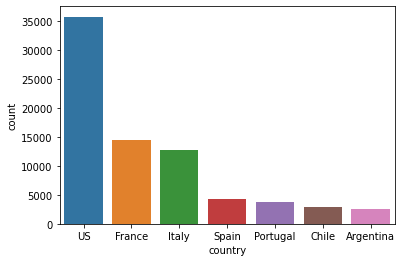

In [16]:
sns.countplot(x ='country', data = train_data,order=train_data["country"].value_counts().iloc[:7].index) 


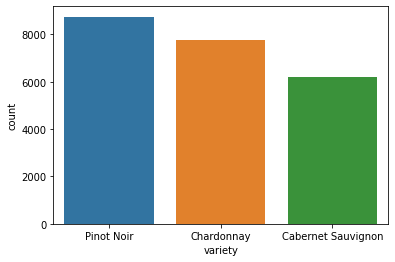

In [17]:
sns.countplot(x ='variety', data = train_data,order=train_data["variety"].value_counts().iloc[:3].index) 


In [18]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_data.drop(['points'], axis=1),
                                                    train_data['points'],
                                                    test_size=0.2,
                                                    random_state=0)

X_train.shape, X_val.shape

((68139, 7), (17035, 7))

In [19]:
numerical = numerical.remove("points")

In [20]:
!pip install feature_engine

In [24]:
from feature_engine import missing_data_imputers

ImportError: ignored

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from feature_engine.imputation import (
    AddMissingIndicator,
    MeanMedianImputer,
    CategoricalImputer,
    ) 
#from feature_engine import missing_data_imputers as mdi
#from feature_engine import categorical_encoders as ce
from feature_engine.encoding import RareLabelEncoder, MeanEncoder

#from feature_engine.variable_transformers import YeoJohnsonTransformer
from sklearn.preprocessing import StandardScaler
#from feature_engine.discretisers import DecisionTreeDiscretiser
from math import sqrt
from sklearn.metrics import mean_squared_error

In [32]:
wine_quality_preprocess = Pipeline([
    
    # missing data imputation 
    ('imputer_numerical', MeanMedianImputer(imputation_method='median',
                                          variables=numerical)),
    ('imputer_categorical', CategoricalImputer(variables=categorical)),

    # categorical encoding 
     ('rare_label_enc', RareLabelEncoder(
         tol=0.01,n_categories=6, variables=categorical)),
    ('categorical_enc', MeanEncoder(variables = categorical)),
     
    # feature Scaling
    ('scaler', StandardScaler()),
])

In [33]:
wine_quality_preprocess.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('imputer_numerical',
                 MeanMedianImputer(imputation_method='median',
                                   variables=['price'])),
                ('imputer_categorical',
                 CategoricalImputer(fill_value='Missing',
                                    imputation_method='missing',
                                    return_object=False,
                                    variables=['country', 'designation',
                                               'province', 'region_1',
                                               'variety', 'winery'])),
                ('rare_label_enc',
                 RareLabelEncoder(max_n_categories=None, n_categories=6,
                                  replace_with='Rare', tol=0.01,
                                  variables=['country', 'designation',
                                             'province', 'region_1', 'variety',
                                             'winery'])),
  

In [34]:
X_train=wine_quality_preprocess.transform(X_train)
X_val=wine_quality_preprocess.transform(X_val)

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
ridge = Ridge()

#define a list of parameters
param_ridge = {'alpha':[1000,2000,3000,4000,5000] }

grid_ridge = GridSearchCV(ridge, param_ridge, cv=5, return_train_score = True)
grid_ridge.fit(X_train, y_train)

# Mean Cross Validation Score
print("Best Cross-validation score: {}".format(grid_ridge.best_score_))

print()

#print best parameters
print('Ridge best parameters: ', grid_ridge.best_params_)


# Check test data set performance
print("L2 regularized linear regression Train Score:",grid_ridge.score(X_train,y_train))
print("L2 regularized linear regression Test Performance: ", grid_ridge.score(X_val,y_val))


Best Cross-validation score: 0.2312751646805617

Ridge best parameters:  {'alpha': 2000}
L2 regularized linear regression Train Score: 0.2346161338560666
L2 regularized linear regression Test Performance:  0.2484183958030447


In [37]:
X_train_preds = grid_ridge.predict(X_train)
X_val_preds = grid_ridge.predict(X_val)

In [38]:
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('Val rmse: {}'.format(sqrt(mean_squared_error(y_val, X_val_preds))))

train rmse: 2.700356970932612
Val rmse: 2.6676716473085778


In [ ]:
import pickle

In [ ]:
filename = 'wine_quality_non_reviews.sav'
pickle.dump(grid_ridge, open(filename, 'wb'))

## 2.	Create a simple text-based model using a bag-of-words approach and a linear model.We will use review column this time.

In [39]:
public_text = pd.read_csv(folder/"public.csv")
private_text = pd.read_csv(folder/"private.csv")
train_text = pd.read_csv(folder/"train.csv")

In [40]:
train_text=train_text.drop_duplicates(['description','title'])
train_text=train_text.reset_index(drop=True)

In [41]:
train_text = train_text[["description","points"]]

In [42]:

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import string
from wordcloud import WordCloud, STOPWORDS
import re
from nltk.corpus import stopwords

from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import WordPunctTokenizer

In [43]:

train_text['description']= train_text['description'].str.lower()
train_text['description']= train_text['description'].apply(lambda i: re.sub('[^a-zA-Z]',' ', i))  
train_text['description']

0        a buoyant wine  this has delicious acidity and...
1        despite weighing in at     alcohol  this seems...
2        sweet  simple and fruity  this light bodied wi...
3        tastes like a sweet and sour sauce mixed into ...
4        as a one liter package you get one third more ...
                               ...                        
85169    plump red and black fruit is immediately evide...
85170    green and vegetal in aromas and flavors  the n...
85171    named after the pombal  or dovecote at ves vio...
85172    produced from vines with an average age of    ...
85173    plump red cherry notes meet clove  allspice an...
Name: description, Length: 85174, dtype: object

In [44]:
tokenizer = WordPunctTokenizer()
words_descriptions = train_text['description'].apply(tokenizer.tokenize)
words_descriptions.head()

0    [a, buoyant, wine, this, has, delicious, acidi...
1    [despite, weighing, in, at, alcohol, this, see...
2    [sweet, simple, and, fruity, this, light, bodi...
3    [tastes, like, a, sweet, and, sour, sauce, mix...
4    [as, a, one, liter, package, you, get, one, th...
Name: description, dtype: object

In [45]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [46]:
stop_words = stopwords.words('english')
Port_Stem = PorterStemmer()
words_descriptions = words_descriptions.apply(lambda x: [word for word in x if not word in stop_words])
words_descriptions = words_descriptions.apply(lambda x: [Port_Stem.stem(word) for word in x])
train_text['processed_data'] = words_descriptions.apply(lambda x: ' '.join(x))

In [47]:
train_text

,description,points,processed_data
0,a buoyant wine this has delicious acidity and...,89,buoyant wine delici acid soft immedi access te...
1,despite weighing in at alcohol this seems...,86,despit weigh alcohol seem light bodi sweet sty...
2,sweet simple and fruity this light bodied wi...,84,sweet simpl fruiti light bodi wine smell flora...
3,tastes like a sweet and sour sauce mixed into ...,84,tast like sweet sour sauc mix white wine pinea...
4,as a one liter package you get one third more ...,86,one liter packag get one third wine money ceme...
...,...,...,...
85169,plump red and black fruit is immediately evide...,90,plump red black fruit immedi evid wine plum bl...
85170,green and vegetal in aromas and flavors the n...,84,green veget aroma flavor nose deal pea green b...
85171,named after the pombal or dovecote at ves vio...,89,name pombal dovecot ve vio soft readi drink wi...
85172,produced from vines with an average age of ...,88,produc vine averag age year wine age lee bottl...


In [48]:
from sklearn.model_selection import train_test_split
X_train_text, X_val_text, y_train_text, y_val_text = train_test_split(train_text.drop(['description','points'], axis=1),
                                                    train_text['points'],
                                                    test_size=0.2,
                                                    random_state=0)
X_train_text.shape,X_val_text.shape

((68139, 1), (17035, 1))

### Using Bag of Words Approach

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(max_features=1500).fit(X_train_text['processed_data'])
X_train_text_new = vect.transform(X_train_text['processed_data'])

In [ ]:
X_val_text_new = vect.transform(X_val_text['processed_data'])

In [ ]:
ridge = Ridge()

#define a list of parameters
param_ridge = {'alpha':[0.1,1,5,10,20,50] }

grid_ridge_bow = GridSearchCV(ridge, param_ridge, cv=5, return_train_score = True)
grid_ridge_bow.fit(X_train_text_new, y_train_text)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {}".format(grid_ridge_bow.best_score_))

print()

#find best parameters
print('Ridge best parameters: ', grid_ridge_bow.best_params_)

# print co-eff

#print("Ridge.coef_:", grid_ridge.best_estimator_.coef_)
#print("Ridge.intercept_:", grid_ridge.best_estimator_.intercept_)

# Check test data set performance
print("Ridge Train Score:",grid_ridge_bow.score(X_train_text_new,y_train_text))
print("Ridge Test Score:",grid_ridge_bow.score(X_val_text_new,y_val_text))

Best Mean Cross-validation score: 0.6483840707622692

Ridge best parameters:  {'alpha': 20}
Ridge Train Score: 0.6646146495421072
Ridge Test Score: 0.6541042559915845


In [ ]:
X_train_text_preds = grid_ridge_bow.predict(X_train_text_new)
X_val_text_preds = grid_ridge_bow.predict(X_val_text_new)

In [ ]:
print('training data rmse: {}'.format(sqrt(mean_squared_error(y_train_text, X_train_text_preds))))
print('Validation data rmse: {}'.format(sqrt(mean_squared_error(y_val_text, X_val_text_preds))))

training data rmse: 1.7875309571864015
Validation data rmse: 1.8097430244857304


In [ ]:
filename = 'wine_quality_bow.sav'
pickle.dump(grid_ridge_bow, open(filename, 'wb'))

## 3.	Try using n-grams, characters, tf-idf rescaling and possibly other ways to tune the BoW model.

### Using TF-IDF approach

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vect_id = TfidfVectorizer().fit(X_train_text['processed_data'])
X_train_tidf = vect_id.transform(X_train_text['processed_data'])

In [ ]:
X_val_tidf = vect_id.transform(X_val_text['processed_data'])

In [ ]:
ridge = Ridge()

#define a list of parameters
param_ridge = {'alpha':[0.1,1,5,10,20] }

grid_ridge_tidf = GridSearchCV(ridge, param_ridge, cv=5, return_train_score = True)
grid_ridge_tidf.fit(X_train_tidf, y_train_text)

# Mean Cross Validation Score
print("Best Cross-validation score: {}".format(grid_ridge_tidf.best_score_))

print()

#find best parameters
print('L2 Regularized ridge best parameters: ', grid_ridge_tidf.best_params_)


# Check test data set performance
print("L2 Regularized ridge training Score:",grid_ridge_tidf.score(X_train_tidf,y_train_text))
print("L2 Regularized ridge Test Score:",grid_ridge_tidf.score(X_val_tidf,y_val_text))

Best Cross-validation score: 0.6652576158578858

L2 Regularized ridge best parameters:  {'alpha': 1}
L2 Regularized ridge training Score: 0.7318439793909531
L2 Regularized ridge Test Score: 0.6767052556405346


In [ ]:
X_train_preds_tidf = grid_ridge_tidf.predict(X_train_tidf)
X_val_preds_tidf = grid_ridge_tidf.predict(X_val_tidf)

In [ ]:
print('training rmse: {}'.format(sqrt(mean_squared_error(y_train_text, X_train_preds_tidf))))
print('Validation rmse: {}'.format(sqrt(mean_squared_error(y_val_text, X_val_preds_tidf))))

training rmse: 1.5983625798298204
Validation rmse: 1.7496195566119823


In [ ]:
filename = 'wine_quality_tidf.sav'
pickle.dump(grid_ridge_tidf, open(filename, 'wb'))

### Implementing n-grams approach 

In [ ]:
vect_gram = CountVectorizer(ngram_range=(2,2)).fit(X_train_text['processed_data'])
X_train_gram = vect_gram.transform(X_train_text['processed_data'])

In [ ]:
X_val_gram = vect_gram.transform(X_val_text['processed_data'])

In [ ]:
ridge = Ridge()

#define a list of parameters
param_ridge = {'alpha':[20,40,50,60] }

grid_gram = GridSearchCV(ridge, param_ridge, cv=5, return_train_score = True)
grid_gram.fit(X_train_gram, y_train_text)

# Mean Cross Validation Score
print("Best  Cross-validation score: {}".format(grid_gram.best_score_))

print()

#find best parameters
print('L2 regularized linear regression best parameters: ', grid_gram.best_params_)

# print co-eff

#print("Ridge.coef_:", grid_ridge.best_estimator_.coef_)
#print("Ridge.intercept_:", grid_ridge.best_estimator_.intercept_)

# Check test data set performance
print("L2 regularized linear regression Train Score:",grid_gram.score(X_train_gram,y_train_text))
print("L2 regularized linear regression Test Score:",grid_gram.score(X_val_gram,y_val_text))

Best  Cross-validation score: 0.5362135185136666

L2 regularized linear regression best parameters:  {'alpha': 20}
L2 regularized linear regression Train Score: 0.8479553563390098
L2 regularized linear regression Test Score: 0.56020510834505


In [ ]:
X_train_gram_preds = grid_gram.predict(X_train_gram)
X_val_gram_preds = grid_gram.predict(X_val_gram)

In [ ]:
print('training data rmse: {}'.format(sqrt(mean_squared_error(y_train_text, X_train_gram_preds))))
print('Validation data rmse: {}'.format(sqrt(mean_squared_error(y_val_text, X_val_gram_preds))))

training data rmse: 1.2035581829341093
Validation data rmse: 2.0406540829167965


In [ ]:
filename = 'wine_quality_ngram.sav'
pickle.dump(grid_gram, open(filename, 'wb'))

## 4.	Combine review based and non-review based features now

In [ ]:
X_train_text_new,X_train.shape

(<68139x1500 sparse matrix of type '<class 'numpy.int64'>'
 	with 1506357 stored elements in Compressed Sparse Row format>, (68139, 7))

In [ ]:
X_train_combi = X_train_text_new.todense()

In [ ]:
X_train_combi = np.concatenate((X_train_combi,X_train),axis=1)

In [ ]:
X_val_combi = X_val_text_new.todense()

In [ ]:
X_val_combi = np.concatenate((X_val_combi,X_val),axis=1)

In [ ]:
ridge = Ridge()

#define a list of parameters
param_ridge = {'alpha':[20,40,50,60] }

grid_combi = GridSearchCV(ridge, param_ridge, cv=5, return_train_score = True)
grid_combi.fit(X_train_combi, y_train_text)

# Mean Cross Validation Score
print("Best  Cross-validation score: {}".format(grid_combi.best_score_))

print()

#find best parameters
print('L2 regularized linear regression best parameters: ', grid_combi.best_params_)

# print co-eff

#print("Ridge.coef_:", grid_ridge.best_estimator_.coef_)
#print("Ridge.intercept_:", grid_ridge.best_estimator_.intercept_)

# Check test data set performance
print("L2 regularized linear regression Train Score:",grid_combi.score(X_train_combi,y_train_text))
print("L2 regularized linear regression Test Score:",grid_combi.score(X_val_combi,y_val_text))

Best  Cross-validation score: 0.6813631672333968

L2 regularized linear regression best parameters:  {'alpha': 20}
L2 regularized linear regression Train Score: 0.6968814605529466
L2 regularized linear regression Test Score: 0.6891424393356156


In [ ]:
X_train_preds = grid_combi.predict(X_train_combi)
X_val_preds = grid_combi.predict(X_val_combi)

In [ ]:
print('training data rmse: {}'.format(sqrt(mean_squared_error(y_train_text, X_train_preds))))
print('Validation data rmse: {}'.format(sqrt(mean_squared_error(y_val_text, X_val_preds))))

training data rmse: 1.6993693352815036
Validation data rmse: 1.7156354819273751


In [ ]:
filename = 'wine_quality_allfeatures.sav'
pickle.dump(grid_combi, open(filename, 'wb'))

# Now we will try using Pre-trained Word Vectors


## Pretrained Glove

In [49]:
embeddings_dict = {}
with open(folder/"glove.6B.100d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [50]:
embeddings_dict["wine"]

array([-0.47653  ,  0.42094  ,  0.17424  , -0.055753 ,  0.20437  ,
        0.36403  ,  1.0813   ,  0.32602  ,  0.096341 , -0.44363  ,
       -0.74458  , -0.6448   , -0.27985  ,  0.2217   , -1.0897   ,
        0.202    ,  0.8254   , -0.52245  , -0.72036  ,  0.81185  ,
       -0.69102  ,  0.1812   , -0.32257  , -0.83526  , -0.17702  ,
        0.57224  , -0.34872  , -0.72935  , -0.42368  , -1.06     ,
       -0.18188  , -0.084373 ,  0.062678 , -1.3184   ,  0.57558  ,
        1.197    ,  0.30817  ,  0.10862  ,  0.22514  , -0.62833  ,
        0.091748 , -0.82288  , -0.049971 , -0.86486  ,  1.0282   ,
       -0.1852   , -0.69624  , -0.86056  ,  0.22834  , -0.95931  ,
        0.71462  , -0.05277  , -0.6747   ,  0.044696 , -1.131    ,
       -1.5243   , -1.0981   ,  0.57741  ,  1.2551   , -0.64939  ,
        0.59221  ,  0.69888  ,  0.14731  , -0.014479 , -0.036558 ,
       -0.55963  ,  0.72571  , -0.85365  ,  0.86099  , -0.7257   ,
        0.21203  ,  0.97805  ,  0.78385  ,  0.24171  , -0.3819

In [51]:
public_glove_vector = pd.read_csv(folder/"public.csv")
private_glove_vector = pd.read_csv(folder/"private.csv")
train_glove_vector = pd.read_csv(folder/"train.csv")

In [52]:
train_glove_vector=train_glove_vector.drop_duplicates(['description','title'])
train_glove_vector=train_glove_vector.reset_index(drop=True)

In [53]:
train_glove_vector = train_glove_vector[["description","points"]]

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_glove_vector.drop(['points'], axis=1),
                                                    train_glove_vector['points'],
                                                    test_size=0.2,
                                                    random_state=0)

X_train.shape, X_val.shape

((68139, 1), (17035, 1))

In [81]:
def GetAverageFeatureVectors(words, model, num_features):
    featureVec = np.zeros(num_features,dtype="float32")
    nwords = 0
    for word in  words:
        if word in model:
            nwords = nwords + 1
            featureVec = np.add(featureVec,model[word])
    return featureVec

In [80]:

def GetfeatureVectors(reviews, model, num_features):
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")    
    for review in reviews:        
        reviewFeatureVecs[counter] = GetAverageFeatureVectors(review, model, num_features)
        counter = counter+1
    return reviewFeatureVecs

In [82]:
def review_wordlist(review, remove_stopwords=False):
    # 1. Removing html tags
    review_text = BeautifulSoup(review).get_text()
    # 2. Removing non-letter.
    review_text = re.sub("[^a-zA-Z]"," ",review_text)
    # 3. Converting to lower case and splitting
    words = review_text.lower().split()
    # 4. Optionally remove stopwords
    if remove_stopwords:
        stops = set(stopwords.words("english"))     
        words = [w for w in words if not w in stops]
    return(words)

In [83]:
# We have used glove embedding with 100d 
num_features = 100
model = embeddings_dict

In [84]:
from bs4 import BeautifulSoup 
clean_train_reviews = []
for review in X_train['description']:
    clean_train_reviews.append(review_wordlist(review, remove_stopwords=True))

In [66]:
X_train['description'][26854]

"Olive and woodspice outmuscle vivid fruit aromas on the nose. The palate is a bit raw and drawing, but it's fresh. Spicy oak adds depth to racy plum and raspberry flavors, with heat stepping in on the finish. Overall this is a fresh, lively version of Carmenère."

In [61]:
clean_train_reviews[0]

['olive',
 'woodspice',
 'outmuscle',
 'vivid',
 'fruit',
 'aromas',
 'nose',
 'palate',
 'bit',
 'raw',
 'drawing',
 'fresh',
 'spicy',
 'oak',
 'adds',
 'depth',
 'racy',
 'plum',
 'raspberry',
 'flavors',
 'heat',
 'stepping',
 'finish',
 'overall',
 'fresh',
 'lively',
 'version',
 'carmen']

In [85]:
trainDataVecs = GetfeatureVectors(clean_train_reviews, model, num_features)

In [86]:
clean_val_reviews = []
for review in X_val['description']:
    clean_val_reviews.append(review_wordlist(review, remove_stopwords=True))

In [87]:
valDataVecs = GetfeatureVectors(clean_val_reviews, model, num_features)

In [88]:
ridge = Ridge()

#define a list of parameters
param_ridge = {'alpha':[1,10,50,100] }

grid_glove = GridSearchCV(ridge, param_ridge, cv=5, return_train_score = True)
grid_glove.fit(trainDataVecs, y_train)

# Mean Cross Validation Score
print("Best  Cross-validation score: {}".format(grid_glove.best_score_))

print()

#find best parameters
print('L2 regularized ridge linear regression best parameters: ', grid_glove.best_params_)

# print co-eff

#print("Ridge.coef_:", grid_ridge.best_estimator_.coef_)
#print("Ridge.intercept_:", grid_ridge.best_estimator_.intercept_)

# Check test data set performance
print("L2 regularized ridge linear regression Train Score:",grid_glove.score(trainDataVecs,y_train))
print("L2 regularized ridge linear regression Test Score:",grid_glove.score(valDataVecs,y_val))

Best  Cross-validation score: 0.49513122481046545

L2 regularized ridge linear regression best parameters:  {'alpha': 100}
L2 regularized ridge linear regression Train Score: 0.4969255979372185
L2 regularized ridge linear regression Test Score: 0.5023905917846687


In [89]:
X_train_preds = grid_glove.predict(trainDataVecs)
X_val_preds = grid_glove.predict(valDataVecs)

In [90]:
print('training data rmse: {}'.format(sqrt(mean_squared_error(y_train_text, X_train_preds))))
print('Validation data rmse: {}'.format(sqrt(mean_squared_error(y_val_text, X_val_preds))))

training data rmse: 2.189261487702083
Validation data rmse: 2.1706439574461305


In [ ]:
filename = 'wine_quality_pretrained_Glove.sav'
pickle.dump(grid_glove, open(filename, 'wb'))

Pre Trained embedding with glove vectors has less score compared with the Bag of Words.

## Let us Combine Glove and BOW approach

In [ ]:
trainDataVecs.shape,X_train_text_new.shape

((68139, 100), (68139, 1500))

In [ ]:
train_concat = X_train_text_new.todense()
val_concat = X_val_text_new.todense()

In [ ]:
train_concat = np.concatenate((train_concat,trainDataVecs),axis = 1)
val_concat = np.concatenate((val_concat,valDataVecs),axis = 1)

In [ ]:
ridge = Ridge()

#define a list of parameters
param_ridge = {'alpha':[40,50,60,100] }

grid_concat = GridSearchCV(ridge, param_ridge, cv=5, return_train_score = True)
grid_concat.fit(train_concat, y_train)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {}".format(grid_concat.best_score_))

print()

#find best parameters
print('L2 regularized ridge linear regression best parameters: ', grid_concat.best_params_)

# print co-eff

#print("Ridge.coef_:", grid_ridge.best_estimator_.coef_)
#print("Ridge.intercept_:", grid_ridge.best_estimator_.intercept_)

# Check test data set performance
print("L2 regularized ridge linear regression Train Score:",grid_concat.score(train_concat,y_train))
print("L2 regularized ridge linear regression Test Score:",grid_concat.score(val_concat,y_val))

Best Mean Cross-validation score: 0.6599865244549775

L2 regularized ridge linear regression best parameters:  {'alpha': 40}
L2 regularized ridge linear regression Train Score: 0.6759035273787166
L2 regularized ridge linear regression Test Score: 0.6657910118313618


In [ ]:
X_train_preds = grid_concat.predict(train_concat)
X_val_preds = grid_concat.predict(val_concat)

In [ ]:
print('training data rmse: {}'.format(sqrt(mean_squared_error(y_train_text, X_train_preds))))
print('Validation data rmse: {}'.format(sqrt(mean_squared_error(y_val_text, X_val_preds))))

training data rmse: 1.7571898240044677
Validation data rmse: 1.7789074951226718


In [ ]:
filename = 'wine_quality_glove_bow.sav'
pickle.dump(grid_concat, open(filename, 'wb'))

We will try Custom Embedding(word2vec) skip gram model 

In [91]:
public_custom = pd.read_csv(folder/"public.csv")
private_cusom = pd.read_csv(folder/"private.csv")
train_custom = pd.read_csv(folder/"train.csv")

In [92]:
train_custom=train_custom.drop_duplicates(['description','title'])
train_custom=train_custom.reset_index(drop=True)

In [93]:
train_custom = train_custom[["description","points"]]

In [95]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_custom.drop(['points'], axis=1),
                                                    train_custom['points'],
                                                    test_size=0.2,
                                                    random_state=0)

X_train.shape, X_val.shape

((68139, 1), (17035, 1))

In [96]:
# we will try skip gram approach
from gensim.models import Word2Vec
import time
# Skip-gram model (sg = 1),sg=0 (CBOW) 
size = 1000
window = 3
min_count = 1
workers = 3
sg = 1

In [97]:
from gensim.utils import simple_preprocess
# Tokenize the text column to get the new column 'tokenized_text'
train_custom['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in train_custom['description']] 
print(train_custom['tokenized_text'].head(10))

0    [buoyant, wine, this, has, delicious, acidity,...
1    [despite, weighing, in, at, alcohol, this, see...
2    [sweet, simple, and, fruity, this, light, bodi...
3    [tastes, like, sweet, and, sour, sauce, mixed,...
4    [as, one, liter, package, you, get, one, third...
5    [this, is, really, drinkable, pinot, noir, it,...
6    [structured, and, elegant, this, opens, with, ...
7    [staunch, but, murky, aromas, of, coffee, grou...
8    [good, everyday, merlot, that, dry, and, softl...
9    [you, ll, love, this, if, you, like, your, zin...
Name: tokenized_text, dtype: object


In [98]:
start_time = time.time()
stemmed_tokens = pd.Series(train_custom['tokenized_text']).values
# Train the Word2Vec Model
w2v_model = Word2Vec(stemmed_tokens, min_count = min_count, size = size, workers = workers, window = window, sg = sg)
print("Time taken to train word2vec model: " + str(time.time() - start_time))

Time taken to train word2vec model: 158.21604824066162


In [99]:
import warnings
warnings.filterwarnings('ignore')
w2v_model.save("Custom_word2vec.model")

In [100]:
num_features = 1000
model = w2v_model

In [101]:
clean_train_custom = []
for review in X_train['description']:
    clean_train_custom.append(review_wordlist(review, remove_stopwords=True))


In [102]:
train_Custom_data = GetfeatureVectors(clean_train_custom, model, num_features)

In [103]:
clean_val_custom = []
for review in X_val['description']:
    clean_val_custom.append(review_wordlist(review, remove_stopwords=True))


In [104]:
validation_custom_Data = GetfeatureVectors(clean_val_custom, model, num_features)

In [105]:
ridge = Ridge()

#define a list of parameters
param_ridge = {'alpha':[1,10,50,100] }

grid_custom = GridSearchCV(ridge, param_ridge, cv=5, return_train_score = True)
grid_custom.fit(train_Custom_data, y_train)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {}".format(grid_custom.best_score_))

print()

#find best parameters
print('L2 regularized ridge linear regression best parameters: ', grid_custom.best_params_)


# Check test data set performance
print("L2 regularized ridge linear regression Train Score:",grid_custom.score(train_Custom_data,y_train))
print("L2 regularized ridge linear regression Test Score:",grid_custom.score(validation_custom_Data,y_val))

Best Mean Cross-validation score: 0.6523268980189398

L2 regularized ridge linear regression best parameters:  {'alpha': 1}
L2 regularized ridge linear regression Train Score: 0.6593360568062963
L2 regularized ridge linear regression Test Score: 0.6579790749897969


In [106]:
X_train_preds = grid_custom.predict(train_Custom_data)
X_val_preds = grid_custom.predict(validation_custom_Data)

In [107]:
print('training data rmse: {}'.format(sqrt(mean_squared_error(y_train_text, X_train_preds))))
print('Validation data rmse: {}'.format(sqrt(mean_squared_error(y_val_text, X_val_preds))))

training data rmse: 1.8015429147493858
Validation data rmse: 1.7995778571883354
